In [ ]:
import re
import pandas as pd

In [ ]:
# ----------- Define Token Types -----------

KEYWORDS = {
    "int", "float", "return", "if", "else", "while",
    "for", "char", "double", "void"     # ← main تم حذفها هنا
}

OPERATORS = {
    "+", "-", "*", "/", "=", "==", "!=", "<", ">",
    "<=", ">=", "++", "--", "%"
}

PUNCTUATION = {
    ";", ",", "(", ")", "{", "}", "[", "]"
}

In [ ]:
# Regex patterns
identifier_pattern = r"[A-Za-z_][A-Za-z0-9_]*"
number_pattern = r"\d+(\.\d+)?"
operator_pattern = r"==|!=|<=|>=|\+\+|--|[+\-*/%=<>(){};,]"
whitespace_pattern = r"\s+"
single_comment_pattern = r"//.*"
multi_comment_pattern = r"/\*[\s\S]*?\*/"
# Combined regex for matching tokens
token_pattern = re.compile(
    f"({multi_comment_pattern})|"
    f"({single_comment_pattern})|"
    f"({identifier_pattern})|"
    f"({number_pattern})|"
    f"({operator_pattern})"
)

In [ ]:
# ----------- Lexical Analyzer Function -----------

def lexical_analyzer(code):
    tokens = []
    symbol_table = {}  # {identifier: {"type": type, "line": x, "count": y}}

    lines = code.split("\n")
    last_type = None  # To store last seen type before identifier

    for line_num, line in enumerate(lines, start=1):
        pos = 0
        last_type = None   # reset every line

        while pos < len(line):

            # Skip whitespace
            ws = re.match(whitespace_pattern, line[pos:])
            if ws:
                pos += ws.end()
                continue

            match = token_pattern.match(line, pos)
            if match:
                token = match.group()

                # Comments
                if re.fullmatch(single_comment_pattern, token) or re.fullmatch(multi_comment_pattern, token):
                    tokens.append((token, "COMMENT", line_num))

                # Keywords
                elif token in KEYWORDS:
                    tokens.append((token, "KEYWORD", line_num))
                    if token in ["int", "float", "char", "double", "void"]:
                        last_type = token

                # Operators
                elif token in OPERATORS:
                    tokens.append((token, "OPERATOR", line_num))

                # Punctuation
                elif token in PUNCTUATION:
                    tokens.append((token, "PUNCTUATION", line_num))

                # Numbers
                elif re.fullmatch(number_pattern, token):
                    tokens.append((token, "NUMBER", line_num))

                # Identifiers
                elif re.fullmatch(identifier_pattern, token):
                    tokens.append((token, "IDENTIFIER", line_num))

                    # Symbol Table handling
                    if token not in symbol_table:
                        symbol_table[token] = {
                            "type": last_type if last_type else "unknown",
                            "line": line_num,
                            "count": 1
                        }
                    else:
                        symbol_table[token]["count"] += 1

                else:
                    tokens.append((token, "UNKNOWN", line_num))

                pos = match.end()

            else:
                # Skip unknown characters
                pos += 1

    return tokens, symbol_table

In [ ]:
# ----------- Test Input -----------

code_input = """
// This is a single-line comment
int x = 5;

/*
   This is
   a multi-line
   comment
*/
int x = 5;
float y = x + 3.14;
if (x > y) {
    x = x + 1;
}
"""

In [ ]:
# ----------- Run Lexer -----------

tokens, symbol_table = lexical_analyzer(code_input)

print("TOKENS:")
for t in tokens:
    print(t)

# ----------- Save Tokens to CSV -----------

df_tokens = pd.DataFrame(tokens, columns=["Token", "Type", "Line"])
df_tokens.to_csv("/content/tokens_output.csv", index=False)
print("\nTokens saved to tokens_output.csv")

TOKENS:
('// This is a single-line comment', 'COMMENT', 2)
('int', 'KEYWORD', 3)
('x', 'IDENTIFIER', 3)
('=', 'OPERATOR', 3)
('5', 'NUMBER', 3)
(';', 'PUNCTUATION', 3)
('/', 'OPERATOR', 5)
('*', 'OPERATOR', 5)
('This', 'IDENTIFIER', 6)
('is', 'IDENTIFIER', 6)
('a', 'IDENTIFIER', 7)
('multi', 'IDENTIFIER', 7)
('-', 'OPERATOR', 7)
('line', 'IDENTIFIER', 7)
('comment', 'IDENTIFIER', 8)
('*', 'OPERATOR', 9)
('/', 'OPERATOR', 9)
('int', 'KEYWORD', 10)
('x', 'IDENTIFIER', 10)
('=', 'OPERATOR', 10)
('5', 'NUMBER', 10)
(';', 'PUNCTUATION', 10)
('float', 'KEYWORD', 11)
('y', 'IDENTIFIER', 11)
('=', 'OPERATOR', 11)
('x', 'IDENTIFIER', 11)
('+', 'OPERATOR', 11)
('3.14', 'NUMBER', 11)
(';', 'PUNCTUATION', 11)
('if', 'KEYWORD', 12)
('(', 'PUNCTUATION', 12)
('x', 'IDENTIFIER', 12)
('>', 'OPERATOR', 12)
('y', 'IDENTIFIER', 12)
(')', 'PUNCTUATION', 12)
('{', 'PUNCTUATION', 12)
('x', 'IDENTIFIER', 13)
('=', 'OPERATOR', 13)
('x', 'IDENTIFIER', 13)
('+', 'OPERATOR', 13)
('1', 'NUMBER', 13)
(';', 'PUNCTUA

In [ ]:
# ----------- Display Symbol Table -----------

df_symbols = pd.DataFrame([
    {"Identifier": ident,
     "Type": data["type"],
     "First Line": data["line"],
     "Occurrences": data["count"]}
    for ident, data in symbol_table.items()
])

print("\nSYMBOL TABLE:")
df_symbols


SYMBOL TABLE:


,Identifier,Type,First Line,Occurrences
0,x,int,3,6
1,This,unknown,6,1
2,is,unknown,6,1
3,a,unknown,7,1
4,multi,unknown,7,1
5,line,unknown,7,1
6,comment,unknown,8,1
7,y,float,11,2


In [ ]:
# =========================================
#                PARSER
#     Fully compatible with your scanner
# =========================================

class Parser:
    def __init__(self, tokens):
        self.tokens = tokens
        self.pos = 0
        self.errors = []

    # ------------------------
    #   Helper Functions
    # ------------------------

    def peek(self):
        if self.pos < len(self.tokens):
            return self.tokens[self.pos]
        return ("EOF", "EOF", -1)

    def advance(self):
        tok = self.peek()
        self.pos += 1
        return tok

    def match(self, val=None, type_=None):
        tok = self.peek()
        v, t, _ = tok
        if (val is None or v == val) and (type_ is None or t == type_):
            self.advance()
            return tok
        return None

    def expect(self, val=None, type_=None):
        tok = self.peek()
        v, t, line = tok
        if (val is None or v == val) and (type_ is None or t == type_):
            return self.advance()
        else:
            self.errors.append(f"Syntax Error at line {line}: Expected {val or type_}, got '{v}' ({t})")
            return self.advance()

    # ------------------------
    #         Parser
    # ------------------------

    def parse(self):
        program = []
        while self.peek()[1] != "EOF":
            program.append(self.parse_external())
        return program, self.errors

    def parse_external(self):
        tok = self.peek()
        val, type_, line = tok

        # Function or global variable
        if type_ == "KEYWORD" and val in {"int", "float", "double", "char", "void"}:
            self.advance()
            id_tok = self.expect(type_="IDENTIFIER")
            name = id_tok[0]

            # Function?
            if self.match("("):
                params = self.parse_params()
                self.expect(")")
                body = self.parse_block()
                return ("Function", name, params, body)

            # Global variable
            init = None
            if self.match("="):
                init = self.parse_expression()
            self.expect(";")
            return ("GlobalDecl", name, init)

        return self.parse_statement()

    # ------------------------
    #     Parameters
    # ------------------------

    def parse_params(self):
        params = []

        if self.peek()[0] == ")":
            return []

        while True:
            type_tok = self.expect(type_="KEYWORD")
            id_tok = self.expect(type_="IDENTIFIER")
            params.append((type_tok[0], id_tok[0]))

            if not self.match(","):
                break

        return params

    # ------------------------
    #     Statements
    # ------------------------

    def parse_statement(self):
        val, t, line = self.peek()

        # Block
        if val == "{" and t == "PUNCTUATION":
            return self.parse_block()

        # if
        if val == "if":
            self.advance()
            self.expect("(")
            cond = self.parse_expression()
            self.expect(")")
            then = self.parse_statement()
            else_part = None
            if self.match("else", "KEYWORD"):
                else_part = self.parse_statement()
            return ("If", cond, then, else_part)

        # while
        if val == "while":
            self.advance()
            self.expect("(")
            cond = self.parse_expression()
            self.expect(")")
            body = self.parse_statement()
            return ("While", cond, body)

        # for
        if val == "for":
            self.advance()
            self.expect("(")
            init = self.parse_expression_statement()
            cond = None
            if self.peek()[0] != ";":
                cond = self.parse_expression()
            self.expect(";")
            incr = None
            if self.peek()[0] != ")":
                incr = self.parse_expression()
            self.expect(")")
            body = self.parse_statement()
            return ("For", init, cond, incr, body)

        # return
        if val == "return":
            self.advance()
            expr = None
            if self.peek()[0] != ";":
                expr = self.parse_expression()
            self.expect(";")
            return ("Return", expr)

        # Declaration
        if t == "KEYWORD" and val in {"int","float","double","char"}:
            type_name = val
            self.advance()
            id_tok = self.expect(type_="IDENTIFIER")
            init = None
            if self.match("="):
                init = self.parse_expression()
            self.expect(";")
            return ("Decl", type_name, id_tok[0], init)

        # Expression statement
        expr = self.parse_expression()
        self.expect(";")
        return ("ExprStmt", expr)

    # ------------------------
    #        Block
    # ------------------------

    def parse_block(self):
        self.expect("{")
        stmts = []
        while self.peek()[0] != "}" and self.peek()[1] != "EOF":
            stmts.append(self.parse_statement())
        self.expect("}")
        return ("Block", stmts)

    # ------------------------
    #     Expression Parsing
    #       Pratt Parser
    # ------------------------

    PRECEDENCE = {
        "||": 1,
        "&&": 2,
        "==": 3, "!=": 3,
        "<": 4, "<=": 4, ">": 4, ">=": 4,
        "+": 5, "-": 5,
        "*": 6, "/": 6, "%": 6
    }

    ASSIGN = {"=", "+=", "-=", "*=", "/="}

    def parse_expression(self, min_prec=0):
        left = self.parse_primary()

        while True:
            tok = self.peek()
            op, t, line = tok

            if t == "OPERATOR" and op in self.PRECEDENCE:
                prec = self.PRECEDENCE[op]
                if prec < min_prec:
                    break

                self.advance()
                right = self.parse_expression(prec + 1)
                left = ("Binary", op, left, right)
                continue

            if t == "OPERATOR" and op in self.ASSIGN:
                self.advance()
                right = self.parse_expression()
                left = ("Assign", op, left, right)
                continue

            break

        return left

    def parse_primary(self):
        val, t, line = self.peek()

        if t == "NUMBER":
            self.advance()
            return ("Number", val)

        if t == "IDENTIFIER":
            self.advance()
            return ("Identifier", val)

        if val == "(":
            self.advance()
            expr = self.parse_expression()
            self.expect(")")
            return expr

        self.errors.append(f"Unexpected token '{val}' at line {line}")
        self.advance()
        return ("Error",)

    def parse_expression_statement(self):
        if self.peek()[0] == ";":
            self.advance()
            return None
        expr = self.parse_expression()
        self.expect(";")
        return expr


In [ ]:
code = """
int main() {
    int i = 0;
    for (i = 0; i < 10; i = i + 1) {
        if (i % 2 == 0) continue;
        int x = i * 2;
    }
    return 0;
}
"""

tokens, table = lexical_analyzer(code)
p = Parser(tokens)
ast, errors = p.parse()
print("Errors:", errors)
print("\nAST:")
for node in ast:
    print(node)


Errors: []

AST:
('Function', 'main', [], ('Block', [('Decl', 'int', 'i', ('Number', '0')), ('For', ('Assign', '=', ('Identifier', 'i'), ('Number', '0')), ('Binary', '<', ('Identifier', 'i'), ('Number', '10')), ('Assign', '=', ('Identifier', 'i'), ('Binary', '+', ('Identifier', 'i'), ('Number', '1'))), ('Block', [('If', ('Binary', '==', ('Binary', '%', ('Identifier', 'i'), ('Number', '2')), ('Number', '0')), ('ExprStmt', ('Identifier', 'continue')), None), ('Decl', 'int', 'x', ('Binary', '*', ('Identifier', 'i'), ('Number', '2')))])), ('Return', ('Number', '0'))]))


In [ ]:
tokens, table = lexical_analyzer(code)
p = Parser(tokens)
ast, errors = p.parse()
print(errors)

[]


In [ ]:
code = """
int main() {
    int i = 0;
    for (i = 0; i < 10; i = i + 1) {
        if (i % 2 == 0) continue;
        int x = i * 2;
    }
    return 0;
}
"""

tokens, table = lexical_analyzer(code)
p = Parser(tokens)
ast, errors = p.parse()

print("Errors:", errors)
print("AST (Raw):\n")

for i, node in enumerate(ast):
    print(f"[Node {i}] {node}")


Errors: []
AST (Raw):

[Node 0] ('Function', 'main', [], ('Block', [('Decl', 'int', 'i', ('Number', '0')), ('For', ('Assign', '=', ('Identifier', 'i'), ('Number', '0')), ('Binary', '<', ('Identifier', 'i'), ('Number', '10')), ('Assign', '=', ('Identifier', 'i'), ('Binary', '+', ('Identifier', 'i'), ('Number', '1'))), ('Block', [('If', ('Binary', '==', ('Binary', '%', ('Identifier', 'i'), ('Number', '2')), ('Number', '0')), ('ExprStmt', ('Identifier', 'continue')), None), ('Decl', 'int', 'x', ('Binary', '*', ('Identifier', 'i'), ('Number', '2')))])), ('Return', ('Number', '0'))]))


In [ ]:
!apt-get install graphviz
!pip install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [ ]:
from graphviz import Digraph

# =====================================================
#               AST VISUALIZER (Graphviz)
# =====================================================

def visualize_ast(ast, filename="AST"):
    dot = Digraph(comment="AST")
    counter = {"id": 0}

    def add_node(node):
        node_id = f"n{counter['id']}"
        counter['id'] += 1

        # ----------- Label ----------
        if isinstance(node, tuple):
            label = node[0]              # نوع العقدة
        elif isinstance(node, list):
            label = "Block"
        else:
            label = str(node)

        dot.node(node_id, label)

        # ----------- Children ----------
        if isinstance(node, tuple):
            for child in node[1:]:
                child_id = add_node(child)
                dot.edge(node_id, child_id)

        elif isinstance(node, list):
            for child in node:
                child_id = add_node(child)
                dot.edge(node_id, child_id)

        return node_id

    add_node(ast)
    return dot


Errors: []


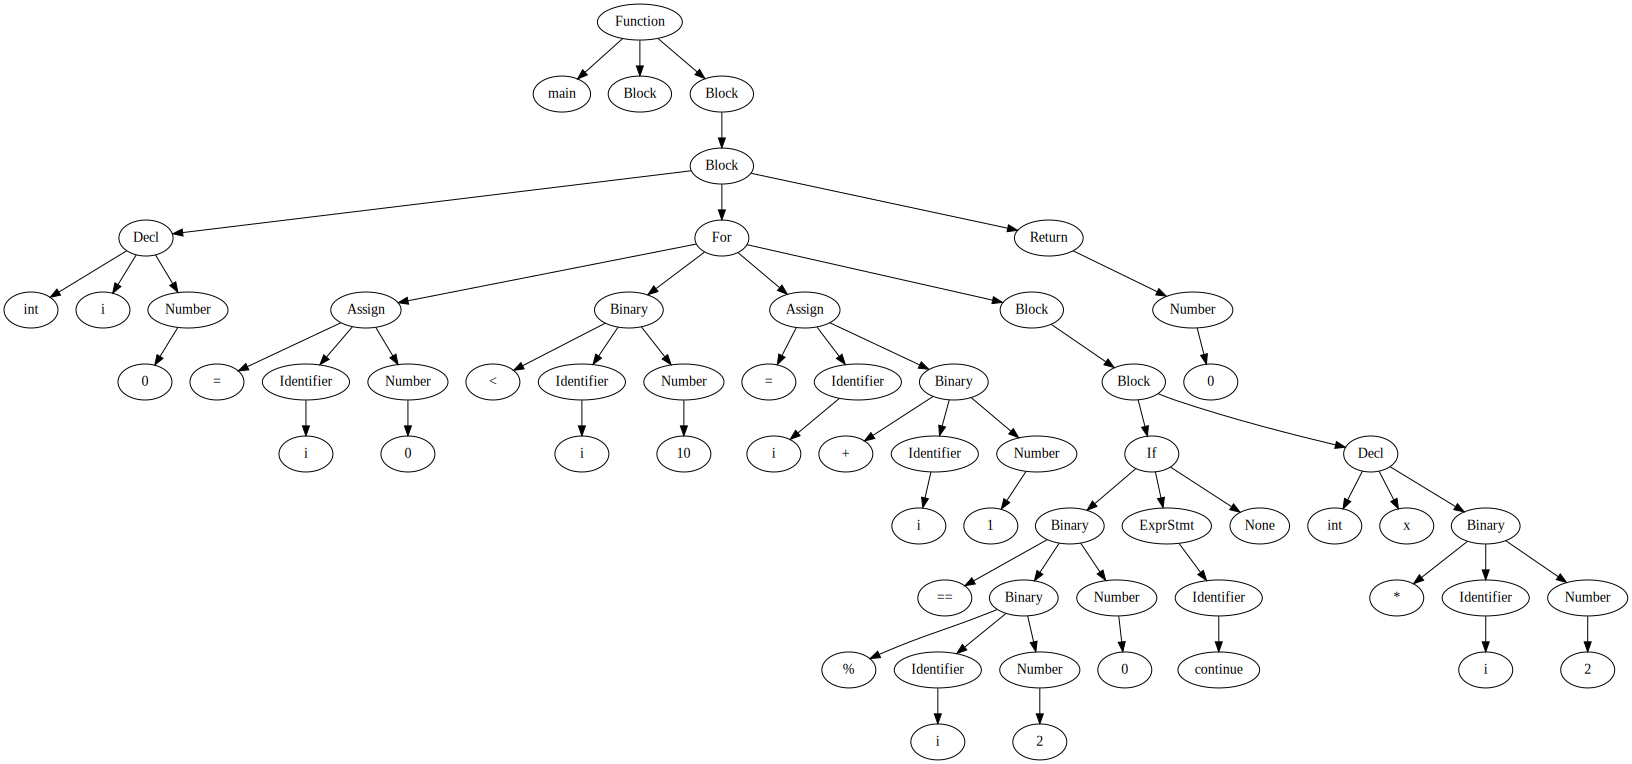

In [ ]:
code = """
int main() {
    int i = 0;
    for (i = 0; i < 10; i = i + 1) {
        if (i % 2 == 0) continue;
        int x = i * 2;
    }
    return 0;
}
"""

tokens, table = lexical_analyzer(code)
p = Parser(tokens)
ast, errors = p.parse()

print("Errors:", errors)

# Drawing the AST
dot = visualize_ast(ast[0])   # ast[0] لأن الـ parser يرجّع قائمة توب-ليفيل
dot
